In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from math import pi
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
sns.set_theme(style="white", context="talk")

import iqplot
import bokeh.io
from bokeh.layouts import column, gridplot
from bokeh.models import ColorBar, ColorMapper, LinearColorMapper, Ticker
bokeh.io.output_notebook()

import sgd_utils as sgd

Loading BokehJS ...

In [2]:
def load_data(f_data, f_movies):
    """Load the user and movie data, FZL modified"""
    data = pd.read_csv(
        "https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project2/data/"+f_data,
        sep="\t",
        header=None,
        names=["USER", "MOVIE", "RATING"],
    )
    movies = pd.read_csv(
        "https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project2/data/"+f_movies,
        encoding="latin-1",
        sep="\t",
        header=None,
        names=[
            "MOVIE_ID",
            "TITLE",
            "UNKNOWN",
            "ACTION",
            "ADVENTURE",
            "ANIMATION",
            "CHILDREN",
            "COMEDY",
            "CRIME",
            "DOCUMENTARY",
            "DRAMA",
            "FANTASY",
            "FILM-NOIR",
            "HORROR",
            "MUSICAL",
            "MYSTERY",
            "ROMANCE",
            "SCI-FI",
            "THRILLER",
            "WAR",
            "WESTERN",
        ],
    )

    movies.loc[movies.TITLE == "unknown", "TITLE"] = "MOVIE_ID: " + movies.loc[
        movies.TITLE == "unknown", "MOVIE_ID"
    ].astype("str")

    return data, movies

In [3]:
data, movies = load_data(f_data="data.txt", f_movies="movies.txt")

## Matrix Factorization visualizations
### Method 1: HW5 solution

In [4]:
Y_train_df = data.head(90000)
Y_train = Y_train_df.to_numpy() # TODO: to be changed later to take train.txt and test.txt, for now I just split data.txt

Y_test_df = data.tail(10000)
Y_test = Y_test_df.to_numpy()

In [5]:
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
Ks = 20

reg = 0.0
eta = 0.03 # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout
U, V, err_training = sgd.train_model(M, N, Ks, eta, reg, Y_train)
print('Err training', err_training)
print('Err testing', sgd.get_err(U, V, Y_test))
print('dim U [m x k]', U.shape)
print('dim V [k x n]', V.shape)


Factorizing with  943  users,  1682  movies.
Epoch 1, E_in (regularized MSE): 0.5366797103643559
Epoch 2, E_in (regularized MSE): 0.4053124391349691
Epoch 3, E_in (regularized MSE): 0.35983058307646
Epoch 4, E_in (regularized MSE): 0.33541290674600593
Epoch 5, E_in (regularized MSE): 0.31490395314617475
Epoch 6, E_in (regularized MSE): 0.304016926538979
Epoch 7, E_in (regularized MSE): 0.29134017991490324
Epoch 8, E_in (regularized MSE): 0.28296440208203666
Epoch 9, E_in (regularized MSE): 0.2780424519801075
Epoch 10, E_in (regularized MSE): 0.2701583731695495
Epoch 11, E_in (regularized MSE): 0.26823010409030484
Epoch 12, E_in (regularized MSE): 0.26706818121829196
Epoch 13, E_in (regularized MSE): 0.2620011295637979
Epoch 14, E_in (regularized MSE): 0.26010099145244847
Epoch 15, E_in (regularized MSE): 0.2581305726483904
Epoch 16, E_in (regularized MSE): 0.25743153728743606
Epoch 17, E_in (regularized MSE): 0.26097393110135225
Err training 0.26097393110135225
Err testing 0.7148557382

In [6]:
## SVD

A, sigma, B = np.linalg.svd(V,  full_matrices=False)
A_two_cols = A[:, 0:2]

U_proj = A_two_cols.transpose()@U.transpose()
V_proj = A_two_cols.transpose()@V


In [7]:
def get_list_movies(data, head_no):
    """ selects the first head_no items from data and returns 3 lists of ids, genre and titles"""   

    list_movies_id = [d[1] for d in data.head(head_no).values]

    list_movies_genre = []
    list_movies_titles = []
    for idx in list_movies_id:
        movie_id_df = movies[movies["MOVIE_ID"] == idx]
        list_cols = []
        for i, v in enumerate(movie_id_df.values[0,:]):
            if v == 1:
                list_cols.append(movie_id_df.columns[i])
        list_movies_genre.append(list_cols)
        list_movies_titles.append(movie_id_df.values[0,1])
        
    return list_movies_id, list_movies_genre, list_movies_titles

# Some visualizations
def visualize(V_proj, movie_titles, movie_genre):
    """ Plots V_proj with annotations from the lists of ids, genre and titles"""   

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.axhline(y=0, color='r')
    ax.axvline(x=0, color='r')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    m_proj0 = np.mean(V_proj[0,:])
    m_proj1 = np.mean(V_proj[1,:])
    ax.plot(V_proj[0,:] - m_proj0, V_proj[1,:] - m_proj1,'*')
    ax.set_xlabel('V proj 0')
    ax.set_ylabel('V proj 1')
    offset = 0.01
    for i, txt in enumerate(list_movies_titles):
        ax.annotate(txt, (V_proj[0][i] - m_proj0 + offset, V_proj[1][i] - m_proj1 + offset), fontsize=8)

    for i, txt in enumerate(list_movies_genre):
        ax.annotate(txt, (V_proj[0][i] - m_proj0, V_proj[1][i] - m_proj1 - 5*offset), fontsize=8)

    plt.show()


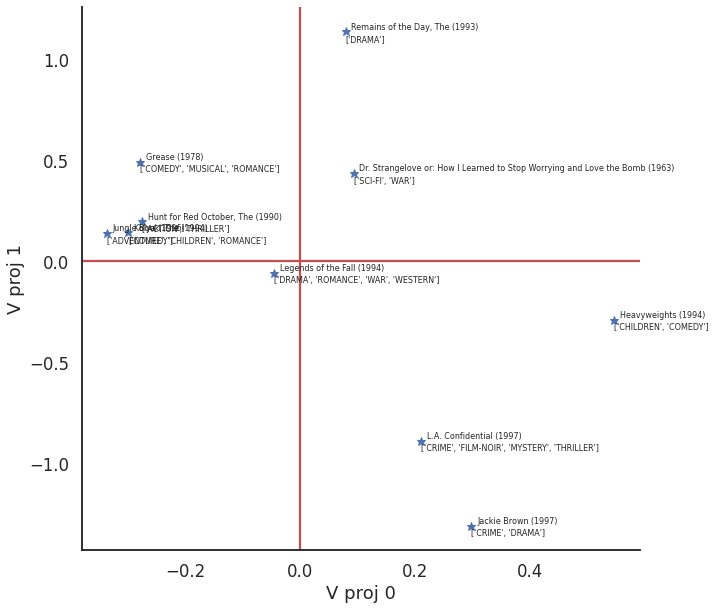

In [8]:
list_movies_id, list_movies_genre, list_movies_titles = get_list_movies(data, head_no=10)
visualize(V_proj[:,0:10], list_movies_titles, list_movies_genre)

### Method 2: Incorporate a and b for each user and move to model global tendencies of the various moves and users TODO

### Method 3: off-the-shelf implementation 

In [9]:
from surprise import SVD, Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn

In [10]:
reader = Reader(rating_scale=(0,5))
train_dataset = Dataset.load_from_df(Y_train_df, reader)

train_dataset_object = train_dataset.build_full_trainset()

algo = SVD()
cross_validate(algo, train_dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

algo.fit(train_dataset_object)

print('pu shape', algo.pu.shape)
print('qi shape', algo.qi.shape)



Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9391  0.9463  0.9404  0.9477  0.9429  0.9433  0.0033  
MAE (testset)     0.7422  0.7468  0.7413  0.7464  0.7432  0.7440  0.0022  
Fit time          2.58    2.58    2.59    2.58    2.58    2.58    0.00    
Test time         0.08    0.08    0.13    0.07    0.07    0.09    0.02    
pu shape (943, 100)
qi shape (1663, 100)


In [11]:
# sample of prediction
uid = str(196)  # raw user id (as in the ratings file). They are **strings**!
iid = str(302)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=4, verbose=True)



user: 196        item: 302        r_ui = 4.00   est = 3.53   {'was_impossible': False}


#### Visualization

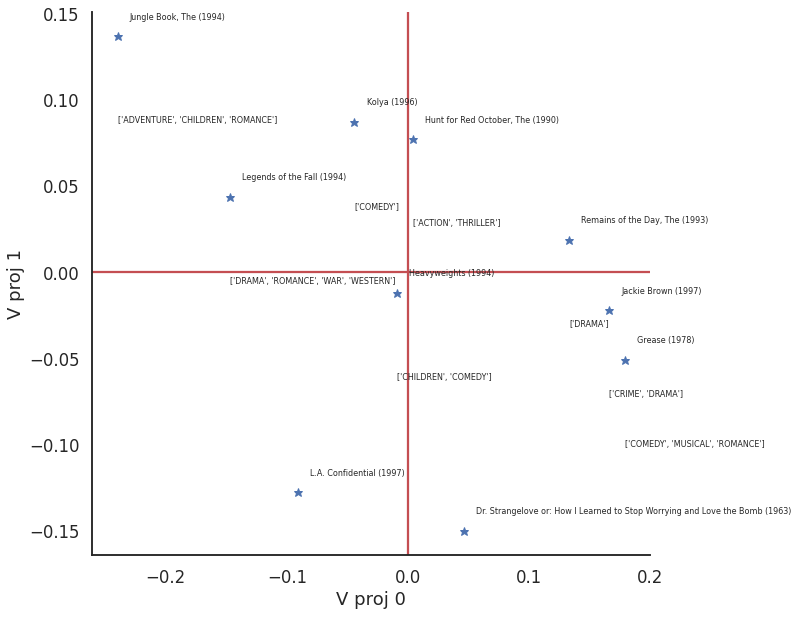

In [12]:
list_movies_id, list_movies_genre, list_movies_titles = get_list_movies(Y_train_df, head_no=10)
visualize(algo.qi[:,0:10], list_movies_titles, list_movies_genre)

# print('pu',algo.pu)
# print('qi',algo.qi)